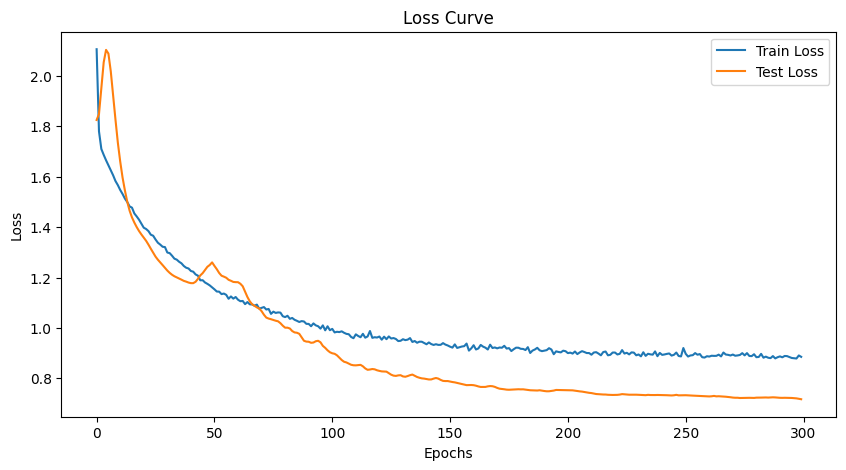

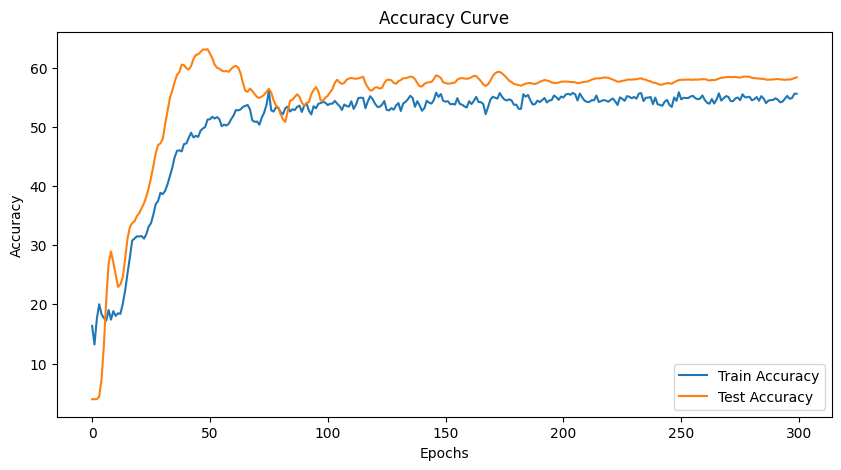

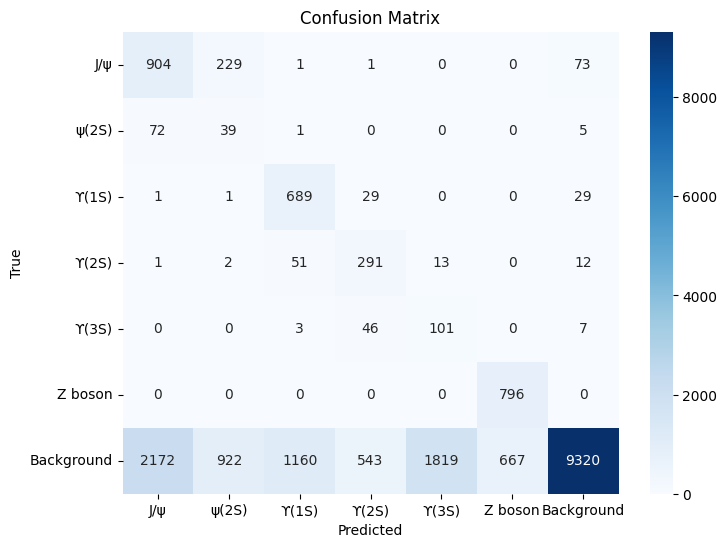

Classification Report:
              precision    recall  f1-score   support

         J/ψ       0.29      0.75      0.41      1208
       ψ(2S)       0.03      0.33      0.06       117
       ϒ(1S)       0.36      0.92      0.52       749
       ϒ(2S)       0.32      0.79      0.45       370
       ϒ(3S)       0.05      0.64      0.10       157
     Z boson       0.54      1.00      0.70       796
  Background       0.99      0.56      0.72     16603

    accuracy                           0.61     20000
   macro avg       0.37      0.71      0.42     20000
weighted avg       0.88      0.61      0.68     20000

Multiclass ROC-AUC: 0.9339
Model saved to data/improved_boson_model.pth


In [3]:
import torch
from torch import nn
from model import ImprovedBoson
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load preprocessed data
X_train = torch.load('data/X_train.pt')
y_train = torch.load('data/y_train.pt').squeeze()
X_test = torch.load('data/X_test.pt')
y_test = torch.load('data/y_test.pt').squeeze()

class_names = {
    0: "J/ψ", 1: "ψ(2S)", 2: "ϒ(1S)", 3: "ϒ(2S)",
    4: "ϒ(3S)", 5: "Z boson", 6: "Background"
}
class_names_list = list(class_names.values())

# Compute class weights
y_train_np = y_train.numpy()
classes = np.arange(7)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weights = torch.tensor(weights, dtype=torch.float32)

# Model
model = ImprovedBoson(input_shape=14, hidden_units=64, output_shape=7)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.010, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Accuracy function
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

# Training loop
train_losses, test_losses = [], []
train_accuracy, test_accuracy = [], []

torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):
    model.train()
    logits = model(X_train)
    preds = torch.argmax(logits, dim=1)
    loss = loss_fn(logits, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = accuracy_fn(y_train, preds)
    train_losses.append(loss.item())
    train_accuracy.append(acc)

    model.eval()
    with torch.no_grad():
        test_logits = model(X_test)
        test_preds = torch.argmax(test_logits, dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)
        test_losses.append(test_loss.item())
        test_accuracy.append(test_acc)

    scheduler.step()

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ----- Thresholded Prediction on Test Data -----

with torch.no_grad():
    test_logits = model(X_test)
    test_probs = torch.softmax(test_logits, dim=1).cpu().numpy()
    y_true = y_test.cpu().numpy()

# Define custom thresholds (can be tuned)
thresholds = np.array([0.30,  # J/ψ
                       0.25,  # ψ(2S)
                       0.30,  # ϒ(1S)
                       0.25,  # ϒ(2S)
                       0.40,  # ϒ(3S)
                       0.50,  # Z boson
                       0.40]) # Background

# Apply threshold-based classification
adjusted_preds = []
for prob in test_probs:
    above_thresh = (prob >= thresholds)
    if np.any(above_thresh):
        adjusted_preds.append(np.argmax(prob * above_thresh))
    else:
        adjusted_preds.append(6)  # Default to Background

# ----- Evaluation -----

# Confusion Matrix
cm = confusion_matrix(y_true, adjusted_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_list, yticklabels=class_names_list)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, adjusted_preds, target_names=class_names_list))

# Multiclass ROC-AUC
y_bin = label_binarize(y_true, classes=np.arange(7))
roc_auc = roc_auc_score(y_bin, test_probs, multi_class='ovr')
print(f"Multiclass ROC-AUC: {roc_auc:.4f}")

# Save model
torch.save(model.state_dict(), "data/improved_boson_model.pth")
print("Model saved to data/improved_boson_model.pth")


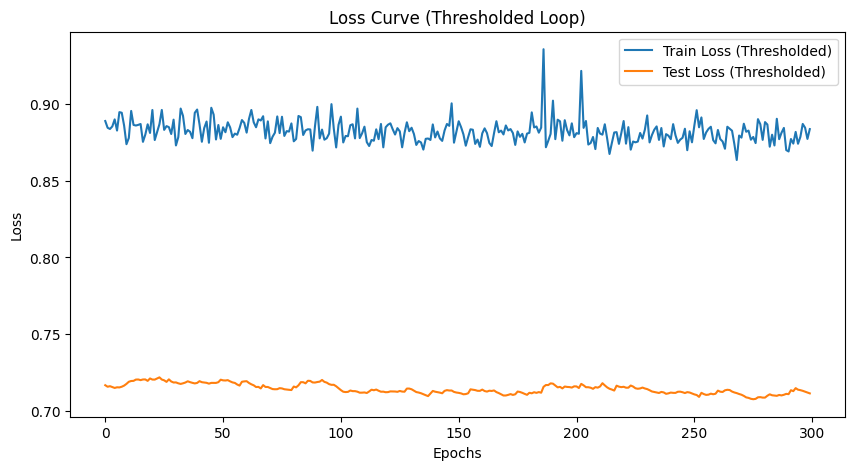

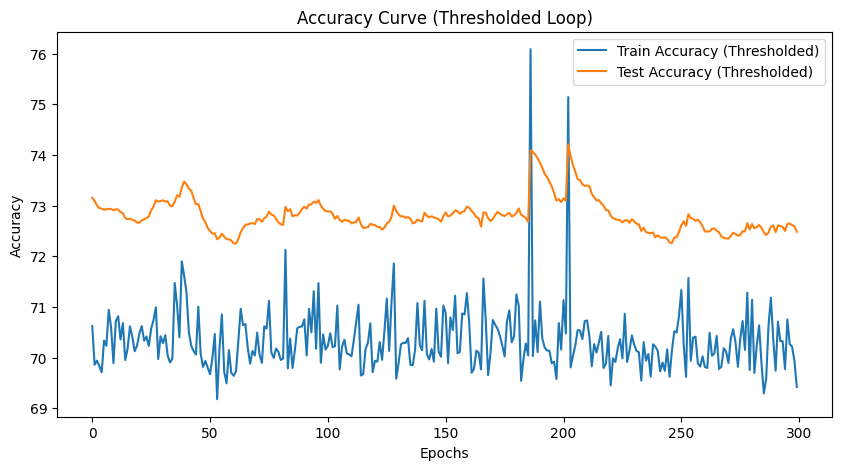

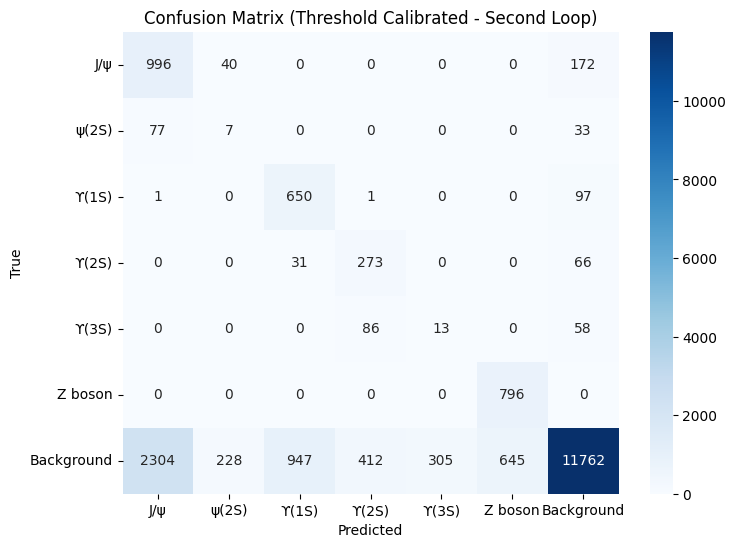

Classification Report (Threshold Calibrated - Second Loop):
              precision    recall  f1-score   support

         J/ψ       0.29      0.82      0.43      1208
       ψ(2S)       0.03      0.06      0.04       117
       ϒ(1S)       0.40      0.87      0.55       749
       ϒ(2S)       0.35      0.74      0.48       370
       ϒ(3S)       0.04      0.08      0.05       157
     Z boson       0.55      1.00      0.71       796
  Background       0.97      0.71      0.82     16603

    accuracy                           0.72     20000
   macro avg       0.38      0.61      0.44     20000
weighted avg       0.86      0.72      0.76     20000

Multiclass ROC-AUC (Second Loop): 0.9340
Model saved to data/improved_boson_model_threshold_loop.pth


In [4]:
# Define custom thresholds (can be tuned)
thresholds = np.array([0.4,  # J/ψ
                       0.5,  # ψ(2S)
                       0.4,  # ϒ(1S)
                       0.375,  # ϒ(2S)
                       0.625,  # ϒ(3S)
                       0.6,  # Z boson
                       0.30]) # Background

# Apply threshold-based classification
adjusted_preds = []
for prob in test_probs:
    above_thresh = (prob >= thresholds)
    if np.any(above_thresh):
        adjusted_preds.append(np.argmax(prob * above_thresh))
    else:
        adjusted_preds.append(6)  # Default to Background

# Second training/testing loop with thresholded predictions
threshold_train_losses, threshold_test_losses = [], []
threshold_train_accuracy, threshold_test_accuracy = [], []

for epoch in range(epochs):
    model.train()
    logits_train_thresh = model(X_train)
    probs_train_thresh = torch.softmax(logits_train_thresh, dim=1).detach().cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    
    # Threshold-based train predictions
    adjusted_train_preds = []
    for prob in probs_train_thresh:
        above_thresh = (prob >= thresholds)
        if np.any(above_thresh):
            adjusted_train_preds.append(np.argmax(prob * above_thresh))
        else:
            adjusted_train_preds.append(6)  # Default to Background
    adjusted_train_preds = torch.tensor(adjusted_train_preds)
    
    # Compute loss and backprop (use raw logits and original labels)
    loss_train_thresh = loss_fn(logits_train_thresh, y_train)
    optimizer.zero_grad()
    loss_train_thresh.backward()
    optimizer.step()
    
    # Train accuracy using thresholded preds
    acc_train_thresh = (adjusted_train_preds == y_train).sum().item() / len(y_train) * 100
    
    threshold_train_losses.append(loss_train_thresh.item())
    threshold_train_accuracy.append(acc_train_thresh)
    
    # Final thresholded predictions after the second loop
    model.eval()
    with torch.no_grad():
        final_test_logits = model(X_test)
        test_probs_thresh = torch.softmax(final_test_logits, dim=1).cpu().numpy()
        y_true_thresh = y_test.cpu().numpy()

        adjusted_preds_thresh = []
        for prob in test_probs_thresh:
            above_thresh = (prob >= thresholds)
            if np.any(above_thresh):
                adjusted_preds_thresh.append(np.argmax(prob * above_thresh))
            else:
                adjusted_preds_thresh.append(6)

        adjusted_test_preds = torch.tensor(adjusted_preds_thresh)
        
        loss_test_thresh = loss_fn(final_test_logits, y_test)
        acc_test_thresh = (adjusted_test_preds == y_test).sum().item() / len(y_test) * 100
        
        threshold_test_losses.append(loss_test_thresh.item())
        threshold_test_accuracy.append(acc_test_thresh)
    
    scheduler.step()

    # Plot loss curve for thresholded training/testing loop
plt.figure(figsize=(10, 5))
plt.plot(threshold_train_losses, label='Train Loss (Thresholded)')
plt.plot(threshold_test_losses, label='Test Loss (Thresholded)')
plt.title('Loss Curve (Thresholded Loop)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curve for thresholded training/testing loop
plt.figure(figsize=(10, 5))
plt.plot(threshold_train_accuracy, label='Train Accuracy (Thresholded)')
plt.plot(threshold_test_accuracy, label='Test Accuracy (Thresholded)')
plt.title('Accuracy Curve (Thresholded Loop)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm_thresh = confusion_matrix(y_true_thresh, adjusted_preds_thresh)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_thresh, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_list, yticklabels=class_names_list)
plt.title("Confusion Matrix (Threshold Calibrated - Second Loop)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("Classification Report (Threshold Calibrated - Second Loop):")
print(classification_report(y_true_thresh, adjusted_preds_thresh, target_names=class_names_list))

# Multiclass ROC-AUC
y_bin_thresh = label_binarize(y_true_thresh, classes=np.arange(7))
roc_auc_thresh = roc_auc_score(y_bin_thresh, test_probs_thresh, multi_class='ovr')
print(f"Multiclass ROC-AUC (Second Loop): {roc_auc_thresh:.4f}")

# Save model after second loop
torch.save(model.state_dict(), "data/improved_boson_model_threshold_loop.pth")
print("Model saved to data/improved_boson_model_threshold_loop.pth")



Even after all the thresholding work, the accuracy remains at 71%. Analysing the results:


Precision = TP / (TP + FP) → Low precision = many false positives

Recall = TP / (TP + FN) → Low recall = many false negatives

F1-score is the harmonic mean of precision and recall.

| Class          | Precision | Recall | F1   | Support | False Positives   | False Negatives        | Notes                                                     |
| -------------- | --------- | ------ | ---- | ------- | ----------------- | ---------------------- | --------------------------------------------------------- |
| **J/ψ**        | 0.29      | 0.80   | 0.43 | 1208    | 🔺 High FP        | 🔻 Low FN              | Model predicts too many as J/ψ; but catches most real J/ψ |
| **ψ(2S)**      | 0.04      | 0.14   | 0.06 | 117     | 🔺🔺 Very high FP | 🔻🔻 Most ψ(2S) missed | Class is highly confused with others; model is unsure     |
| **ϒ(1S)**      | 0.42      | 0.83   | 0.56 | 749     | 🔺 Moderate FP    | 🔻 Low FN              | Good catch rate, but predicts it a bit too often          |
| **ϒ(2S)**      | 0.38      | 0.73   | 0.50 | 370     | Moderate FP       | Moderate FN            | Balanced — small improvements may help                    |
| **ϒ(3S)**      | 0.05      | 0.21   | 0.08 | 157     | 🔺🔺 Huge FP      | 🔻🔻 Huge FN           | Model is guessing; weak class separation                  |
| **Z boson**    | 0.55      | 1.00   | 0.71 | 796     | 🔺 Moderate FP    | ✅ Zero FN              | All real Z bosons are caught — possibly over-predicting   |
| **Background** | 0.96      | 0.69   | 0.81 | 16603   | ✅ Low FP          | 🔻 High FN             | Many background events are misclassified as signals       |

If you were trying to predict everything correctly, you would most likely need to increase the samples of the less represented classes in order to make the model train on them more. However, since the focus of this project is  on Z Bosons - we catch all real Z Bosons, which is the most useful scenario for us. False Positives are acceptable as long as there are no False Negatives, because we filter out the true Z Boson events in the end anyways. Using the threshold boundaries, our base accuracy is over 70%, but the model doesn't seem to be learning anymore.